# import

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import kstest, gaussian_kde, ks_2samp, chi2_contingency, wasserstein_distance
from sdv.metadata import SingleTableMetadata

In [2]:
set_verbosity(ERROR)

# load data

In [3]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [4]:
real_data_collection = load_data_collection("gtfs")

In [5]:
del real_data_collection['shapes']

## Create Metadata

In [6]:
def auto_detect_relation(data_collection):
    metadata = {}
    for df_name, df in data_collection.items():
        parent = {}
        child = []
        primary_key = []
        foreign_key = []
        for col in df.columns:
            if 'id' in col:
                if df[col].nunique() == len(df):
                    primary_key = [col, len(df)]
                else:
                    foreign_key.append(col)
        for foreign_df_name, foreign_df in data_collection.items():
            if foreign_df_name != df_name:
                for col in foreign_df.columns:
                    if 'id' in col:
                        for fr_k in foreign_key:
                            if col == fr_k and foreign_df[col].nunique() == len(foreign_df):
                                parent[foreign_df_name] = fr_k
                        if primary_key != []:
                            if col == primary_key[0] and foreign_df[col].nunique() != len(foreign_df):
                                child.append(foreign_df_name)
        metadata[df_name] = {'primary_key':primary_key,
                             'parent':parent,
                             'child':child}
    return metadata

In [7]:
realtions = auto_detect_relation(real_data_collection)

In [8]:
realtions

{'agency': {'primary_key': ['agency_id', 15],
  'parent': {},
  'child': ['routes']},
 'calendar': {'primary_key': ['service_id', 121],
  'parent': {},
  'child': ['calendar_dates', 'trips']},
 'calendar_dates': {'primary_key': [],
  'parent': {'calendar': 'service_id'},
  'child': []},
 'routes': {'primary_key': ['route_id', 215],
  'parent': {'agency': 'agency_id'},
  'child': ['trips']},
 'stops': {'primary_key': ['stop_id', 6714],
  'parent': {},
  'child': ['stop_times']},
 'stop_times': {'primary_key': [],
  'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
  'child': []},
 'trips': {'primary_key': ['trip_id', 32403],
  'parent': {'calendar': 'service_id', 'routes': 'route_id'},
  'child': ['stop_times']}}

In [9]:
# {'agency': {'primary_key': ['agency_id', 15],
#   'parent': {},
#   'child': ['routes']},
#  'calendar': {'primary_key': ['service_id', 121],
#   'parent': {},
#   'child': ['calendar_dates', 'trips']},
#  'calendar_dates': {'primary_key': [],
#   'parent': {'calendar': 'service_id'},
#   'child': []},
#  'routes': {'primary_key': ['route_id', 215],
#   'parent': {'agency': 'agency_id'},
#   'child': ['trips']},
#  'stops': {'primary_key': ['stop_id', 6714],
#   'parent': {},
#   'child': ['stop_times']},
#  'stop_times': {'primary_key': [],
#   'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
#   'child': []},
#  'trips': {'primary_key': ['trip_id', 32403],
#   'parent': {'calendar': 'service_id', 'routes': 'route_id'},
#   'child': ['stop_times']}}

# preprocess

## Create Factorization Dictionary:

In [10]:
def create_factorization_dict(data_collection, realtions):
    factor_dict = {}
    for df_name, df in data_collection.items():
        local_id_dict = {}
        primary_key_info = realtions[df_name]['primary_key']
        if primary_key_info != []:
            local_id_dict = {k:v for v,k in enumerate(df[primary_key_info[0]].unique())}
            factor_dict[primary_key_info[0]] = local_id_dict
    return factor_dict

In [11]:
factorization_dict = create_factorization_dict(real_data_collection, realtions)

## Format Individual Table:

In [12]:
def individual_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [13]:
def format_individual_data(data, preprocess_dict, factorization_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            if col in factorization_dict.keys():
                                data[col] = data[col].map(factorization_dict[col])
                            else:
                                data[col] = pd.factorize(data[col], sort=True)[0].astype(int)
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '')
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

## preprocess individual data

In [14]:
metadata_collection = {}

### agency

In [15]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_name','agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id','agency_url','agency_timezone','agency_lang','agency_phone']
real_data_collection['agency'] = format_individual_data(real_data_collection['agency'], preprocess_dict, factorization_dict)

In [16]:
metadata_collection['agency'] = SingleTableMetadata()
metadata_collection['agency'].detect_from_dataframe(data=real_data_collection['agency'])
metadata_collection['agency'].update_column(column_name='agency_id',sdtype='id')
metadata_collection['agency'].update_column(column_name='agency_url',sdtype='categorical')
metadata_collection['agency'].update_column(column_name='agency_timezone',sdtype='categorical')
metadata_collection['agency'].update_column(column_name='agency_lang',sdtype='categorical')
metadata_collection['agency'].update_column(column_name='agency_phone',sdtype='categorical')
metadata_collection['agency'].set_primary_key(column_name='agency_id')

### calendar

In [17]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = format_individual_data(real_data_collection['calendar'], preprocess_dict, factorization_dict)

In [18]:
metadata_collection['calendar'] = SingleTableMetadata()
metadata_collection['calendar'].detect_from_dataframe(data=real_data_collection['calendar'])
metadata_collection['calendar'].update_column(column_name='service_id',sdtype='id')
metadata_collection['calendar'].update_column(column_name='monday',sdtype='categorical')
metadata_collection['calendar'].update_column(column_name='tuesday',sdtype='categorical')
metadata_collection['calendar'].update_column(column_name='wednesday',sdtype='categorical')
metadata_collection['calendar'].update_column(column_name='thursday',sdtype='categorical')
metadata_collection['calendar'].update_column(column_name='friday',sdtype='categorical')
metadata_collection['calendar'].update_column(column_name='saturday',sdtype='categorical')
metadata_collection['calendar'].update_column(column_name='sunday',sdtype='categorical')
metadata_collection['calendar'].update_column(column_name='start_date',sdtype='numerical',computer_representation='Int32')
metadata_collection['calendar'].update_column(column_name='end_date',sdtype='numerical',computer_representation='Int32')
metadata_collection['calendar'].set_primary_key(column_name='service_id')

### calendar_dates

In [19]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = format_individual_data(real_data_collection['calendar_dates'], preprocess_dict, factorization_dict)

In [20]:
metadata_collection['calendar_dates'] = SingleTableMetadata()
metadata_collection['calendar_dates'].detect_from_dataframe(data=real_data_collection['calendar_dates'])
metadata_collection['calendar_dates'].update_column(column_name='service_id',sdtype='id')
metadata_collection['calendar_dates'].update_column(column_name='date',sdtype='numerical',computer_representation='Int32')
metadata_collection['calendar_dates'].update_column(column_name='exception_type',sdtype='categorical')

### routes

In [21]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_short_name','route_long_name','route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = format_individual_data(real_data_collection['routes'], preprocess_dict, factorization_dict)

In [22]:
real_data_collection['routes']['route_color'] = real_data_collection['routes']['route_color'].astype(int)
real_data_collection['routes']['route_text_color'] = real_data_collection['routes']['route_text_color'].astype(int)

In [24]:
metadata_collection['routes'] = SingleTableMetadata()
metadata_collection['routes'].detect_from_dataframe(data=real_data_collection['routes'])
metadata_collection['routes'].update_column(column_name='route_id',sdtype='id')
metadata_collection['routes'].update_column(column_name='agency_id',sdtype='id')
metadata_collection['routes'].update_column(column_name='route_type',sdtype='categorical')
metadata_collection['routes'].update_column(column_name='route_color',sdtype='categorical')
metadata_collection['routes'].update_column(column_name='route_text_color',sdtype='categorical')
metadata_collection['routes'].update_column(column_name='contract_id',sdtype='id')
metadata_collection['routes'].set_primary_key(column_name='route_id')

### stops

In [25]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_name','stop_code','stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = format_individual_data(real_data_collection['stops'], preprocess_dict, factorization_dict)

In [26]:
real_data_collection['stops']['parent_station'] = real_data_collection['stops']['parent_station'].astype(int)
real_data_collection['stops']['platform_code'] = real_data_collection['stops']['platform_code'].astype(int)

In [27]:
metadata_collection['stops'] = SingleTableMetadata()
metadata_collection['stops'].detect_from_dataframe(data=real_data_collection['stops'])
metadata_collection['stops'].update_column(column_name='stop_id',sdtype='id')
metadata_collection['stops'].update_column(column_name='stop_lat',sdtype='numerical',computer_representation='Float')
metadata_collection['stops'].update_column(column_name='stop_lon',sdtype='numerical',computer_representation='Float')
metadata_collection['stops'].update_column(column_name='location_type',sdtype='categorical')
metadata_collection['stops'].update_column(column_name='parent_station',sdtype='categorical')
metadata_collection['stops'].update_column(column_name='platform_code',sdtype='categorical')
metadata_collection['stops'].update_column(column_name='wheelchair_boarding',sdtype='categorical')
metadata_collection['stops'].update_column(column_name='start_date',sdtype='numerical',computer_representation='Int32')
metadata_collection['stops'].update_column(column_name='end_date',sdtype='numerical',computer_representation='Int32')
metadata_collection['stops'].set_primary_key(column_name='stop_id')

### stop_times

In [28]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = format_individual_data(real_data_collection['stop_times'], preprocess_dict, factorization_dict)

In [29]:
real_data_collection['stop_times']['arrival_time'] = real_data_collection['stop_times']['arrival_time'].astype(int)
real_data_collection['stop_times']['departure_time'] = real_data_collection['stop_times']['departure_time'].astype(int)

In [30]:
metadata_collection['stop_times'] = SingleTableMetadata()
metadata_collection['stop_times'].detect_from_dataframe(data=real_data_collection['stop_times'])
metadata_collection['stop_times'].update_column(column_name='trip_id',sdtype='id')
metadata_collection['stop_times'].update_column(column_name='arrival_time',sdtype='numerical',computer_representation='Int32')
metadata_collection['stop_times'].update_column(column_name='departure_time',sdtype='numerical',computer_representation='Int32')
metadata_collection['stop_times'].update_column(column_name='stop_id',sdtype='id')
metadata_collection['stop_times'].update_column(column_name='stop_sequence',sdtype='categorical')
metadata_collection['stop_times'].update_column(column_name='stop_headsign',sdtype='categorical')
metadata_collection['stop_times'].update_column(column_name='pickup_type',sdtype='categorical')
metadata_collection['stop_times'].update_column(column_name='drop_off_type',sdtype='categorical')
metadata_collection['stop_times'].update_column(column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
metadata_collection['stop_times'].update_column(column_name='timepoint',sdtype='categorical')

### trips

In [31]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = format_individual_data(real_data_collection['trips'], preprocess_dict, factorization_dict)

In [33]:
metadata_collection['trips'] = SingleTableMetadata()
metadata_collection['trips'].detect_from_dataframe(data=real_data_collection['trips'])
metadata_collection['trips'].update_column(column_name='route_id',sdtype='id')
metadata_collection['trips'].update_column(column_name='service_id',sdtype='id')
metadata_collection['trips'].update_column(column_name='trip_id',sdtype='id')
metadata_collection['trips'].update_column(column_name='trip_headsign',sdtype='categorical')
metadata_collection['trips'].update_column(column_name='direction_id',sdtype='id')
metadata_collection['trips'].update_column(column_name='shape_id',sdtype='id')
metadata_collection['trips'].update_column(column_name='wheelchair_accessible',sdtype='categorical')
metadata_collection['trips'].update_column(column_name='bikes_allowed',sdtype='categorical')
metadata_collection['trips'].set_primary_key(column_name='trip_id')

## Scaling

In [34]:
def scale_individual_df(df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [35]:
# def extract_key_and_scaled_features(df, label_columns):
#     labels = df[label_columns]
#     table = df.drop(columns=label_columns)
#     table_column_names = table.columns
#     scaled_table, table_scaler = scale_individual_df(table)
#     scaled_labels, labels_scaler = scale_individual_df(labels)
#     return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [38]:
def batch_preprocessing(data_collection):
    processed_data_collection = {}
    for df_name, df in data_collection.items():
        # primary_key = []
        # foreign_key = []
        # if metadata[df_name]['primary_key'] != []:
        #     primary_key = [metadata[df_name]['primary_key'][0]]
        # if metadata[df_name]['parent'] != {}:
        #     foreign_key = list(metadata[df_name]['parent'].values())
        # label_columns = primary_key + foreign_key
        scaled_df, scaler = scale_individual_df(df)
        processed_data_collection[df_name] = {
            'scaled_data':scaled_df,
            'scaler':scaler,
            'col_names':df.columns
        }
    return processed_data_collection

In [39]:
processed_data_collection = batch_preprocessing(real_data_collection)
# del real_data_collection

# GAN Building

## Additional Custom Function (Wasserstein Loss)

In [40]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [41]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [42]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(discriminator_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, Discriminator

In [43]:
def build_generator(output_dim, latent_dim=100):
    noise_input = layers.Input(shape=(latent_dim,))
    # labels_input = layers.Input(shape=(labels_dim,))
    # merge_input = layers.Concatenate()([noise_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(noise_input)
    hidden_layer1 = layers.Dense(16,activation='LeakyReLU',kernel_initializer='HeUniform')(bn_layer1)
    hidden_layer2 = layers.Dense(32,activation='LeakyReLU')(hidden_layer1)
    hidden_layer3 = layers.Dense(64,activation='LeakyReLU')(hidden_layer2)
    bn_layer2 = layers.BatchNormalization()(hidden_layer3)
    output_layer = layers.Dense(output_dim, activation='tanh')(bn_layer2)
    generator = models.Model(noise_input, output_layer)
    return generator

In [44]:
def build_critic(input_dim, constraint_rate=0.001, optimization_rate=0.00005):
    clip_const = ClipConstraint(constraint_rate)
    rms_opt = optimizers.RMSprop(optimization_rate)
    init = initializers.RandomUniform(minval=-1, maxval=1)
    table_input = layers.Input(shape=(input_dim,))
    # labels_input = layers.Input(shape=(labels_dim,))
    # merge_input = layers.Concatenate()([table_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(table_input)
    hidden_layer1 = layers.Dense(64,activation='LeakyReLU',kernel_constraint=clip_const,kernel_initializer=init)(bn_layer1)
    hidden_layer2 = layers.Dense(32,activation='LeakyReLU',kernel_constraint=clip_const,kernel_initializer=init)(hidden_layer1)
    hidden_layer3 = layers.Dense(16,activation='LeakyReLU',kernel_constraint=clip_const,kernel_initializer=init)(hidden_layer2)
    bn_layer2 = layers.BatchNormalization()(hidden_layer3)
    output_layer = layers.Dense(1, activation='linear')(bn_layer2)
    discriminator = models.Model(table_input, output_layer)
    discriminator.compile(loss=wasserstein_loss, optimizer=rms_opt)
    return discriminator

In [45]:
# def build_critic(table_dim, labels_dim, constraint_rate=0.01, optimization_rate=0.00005):
#     clip_const = ClipConstraint(constraint_rate)
#     rms_opt = optimizers.RMSprop(optimization_rate)
#     init = initializers.RandomUniform(minval=-1, maxval=1, seed=123)
#     table_input = layers.Input(shape=(table_dim,))
#     labels_input = layers.Input(shape=(labels_dim,))
#     merge_input = layers.Concatenate()([table_input, labels_input])
#     bn_layer1 = layers.BatchNormalization()(merge_input)
#     hidden_layer1 = layers.Dense(128,activation='LeakyReLU',kernel_initializer=init)(bn_layer1)
#     reshape_layer = layers.Reshape((4, 32))(hidden_layer1)
#     conv1 = layers.Conv1D(64,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           kernel_constraint=clip_const,
#                           activation="LeakyReLU")(reshape_layer)
#     conv2 = layers.Conv1D(32,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           kernel_constraint=clip_const,
#                           activation="LeakyReLU")(conv1)
#     bn_layer2 = layers.BatchNormalization()(conv2)
#     output_layer = layers.Dense(1, activation='linear')(bn_layer2)
#     discriminator = models.Model([table_input, labels_input], output_layer)
#     discriminator.compile(loss=wasserstein_loss, optimizer=rms_opt)
#     return discriminator

In [46]:
def build_gan(generator, discriminator, optimization_rate=0.00005):
    discriminator.trainable = False
    rms_opt = optimizers.RMSprop(optimization_rate)
    # noise_input = layers.Input(shape=(generator.input_shape[0][1],))
    # labels_input = layers.Input(shape=(generator.input_shape[1][1],))
    # generator_output = generator([noise_input, labels_input])
    # discriminator_output = discriminator([generator_output, labels_input])
    gan = models.Sequential()
    gan.add(generator)
    gan.add(discriminator)
    gan.compile(loss=wasserstein_loss,
                 optimizer=rms_opt)
    # gan = models.Model(inputs=[noise_input, labels_input], outputs=discriminator_output)
    # gan.compile(optimizer=rms_opt, loss=wasserstein_loss)
    return gan

## Define Training Strategy

In [47]:
def train_individual_gan(name, data, n_critic=5, epochs=50, batch_size=200, latent_dim=100, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    # class_counts = real_labels.nunique().tolist()
    # generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    # critic = build_critic(real_table.shape[1], real_labels.shape[1])
    generator = build_generator(data.shape[1], latent_dim=latent_dim)
    critic = build_critic(data.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1 * np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        
        # train critic:
        for _ in range(n_critic):
            idx = np.random.randint(0, data.shape[0], half_batch)
            noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
            x_real = data.iloc[idx]
            x_fake = generator.predict(noise)
            cur_c_loss_real = critic.train_on_batch(x_real, y_real)
            cur_c_loss_fake = critic.train_on_batch(x_fake, y_fake)
            c_loss.append(cur_c_loss_real - cur_c_loss_fake)
            rand_seed ++1

        # train generator/GAN
        x_gan = np.random.uniform(-1, 1, (batch_size, latent_dim))
        # x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=batch_size) for class_counts in class_counts])
        # x_fake_table = generator.predict(x_gan)
        g_loss = gan.train_on_batch(x_gan, y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(np.mean(c_loss))
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"[Epoch: {epoch}] [C loss: {np.round(np.mean(c_loss), 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed ++1
        
    generator.save('models_single/'+name+'_gan.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [52]:
def collection_training(data_collection, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in data_collection.items():
        start_time = time.time()
        print(f'Learning \"{df_name}\" data......')
        latent_dim = 100
        generator_log, critic_log = train_individual_gan(df_name,
                                                         content['scaled_data'],
                                                         epochs=training_parameter_dict[df_name]['epochs'],
                                                         latent_dim = latent_dim,
                                                         return_logs=True)
        in_loop_elapsed_time = time.time() - start_time
        minutes, seconds = divmod(in_loop_elapsed_time, 60)
        print("Time Used: %dm %ds" % (minutes, seconds))
        print('.')
        print('.')
        logs.append([df_name, generator_log, critic_log])
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [49]:
# training_parameter_dict = {}
# for df_name, content in processed_data_collection.items():
#     nrows = content['table'].shape[0]
#     # training_parameter_dict[df_name] = {'epochs':500}
#     if nrows <= 100:
#         training_parameter_dict[df_name] = {'epochs':50}
#     elif nrows <= 10000:
#         training_parameter_dict[df_name] = {'epochs':50}
#     else:
#         training_parameter_dict[df_name] = {'epochs':50}

In [50]:
training_parameter_dict = {'agency': {'epochs': 30},
                           'calendar': {'epochs': 50},
                           'calendar_dates': {'epochs': 50},
                           'routes': {'epochs': 50},
                           'stops': {'epochs': 50},
                           'stop_times': {'epochs': 50},
                           'trips': {'epochs': 40}}

Learning "agency" data......
[Epoch: 0] [C loss: -0.001] [G loss: 0.004] [Speed: 0.27 it/s]
[Epoch: 10] [C loss: -0.001] [G loss: 0.003] [Speed: 3.23 it/s]
[Epoch: 20] [C loss: -0.001] [G loss: 0.002] [Speed: 2.91 it/s]
[Epoch: 29] [C loss: -0.001] [G loss: 0.002] [Speed: 2.87 it/s]
Time Used: 0m 16s
.
.
Learning "calendar" data......
[Epoch: 0] [C loss: -0.001] [G loss: 0.06] [Speed: 0.46 it/s]
[Epoch: 10] [C loss: -0.001] [G loss: 0.037] [Speed: 2.67 it/s]
[Epoch: 20] [C loss: -0.001] [G loss: 0.022] [Speed: 2.62 it/s]
[Epoch: 30] [C loss: -0.001] [G loss: 0.014] [Speed: 2.74 it/s]
[Epoch: 40] [C loss: -0.001] [G loss: 0.009] [Speed: 2.76 it/s]
[Epoch: 49] [C loss: -0.001] [G loss: 0.006] [Speed: 2.81 it/s]
Time Used: 0m 20s
.
.
Learning "calendar_dates" data......
[Epoch: 0] [C loss: -0.001] [G loss: 0.011] [Speed: 0.47 it/s]
[Epoch: 10] [C loss: -0.001] [G loss: 0.008] [Speed: 2.85 it/s]
[Epoch: 20] [C loss: -0.001] [G loss: 0.004] [Speed: 2.91 it/s]
[Epoch: 30] [C loss: -0.001] [G

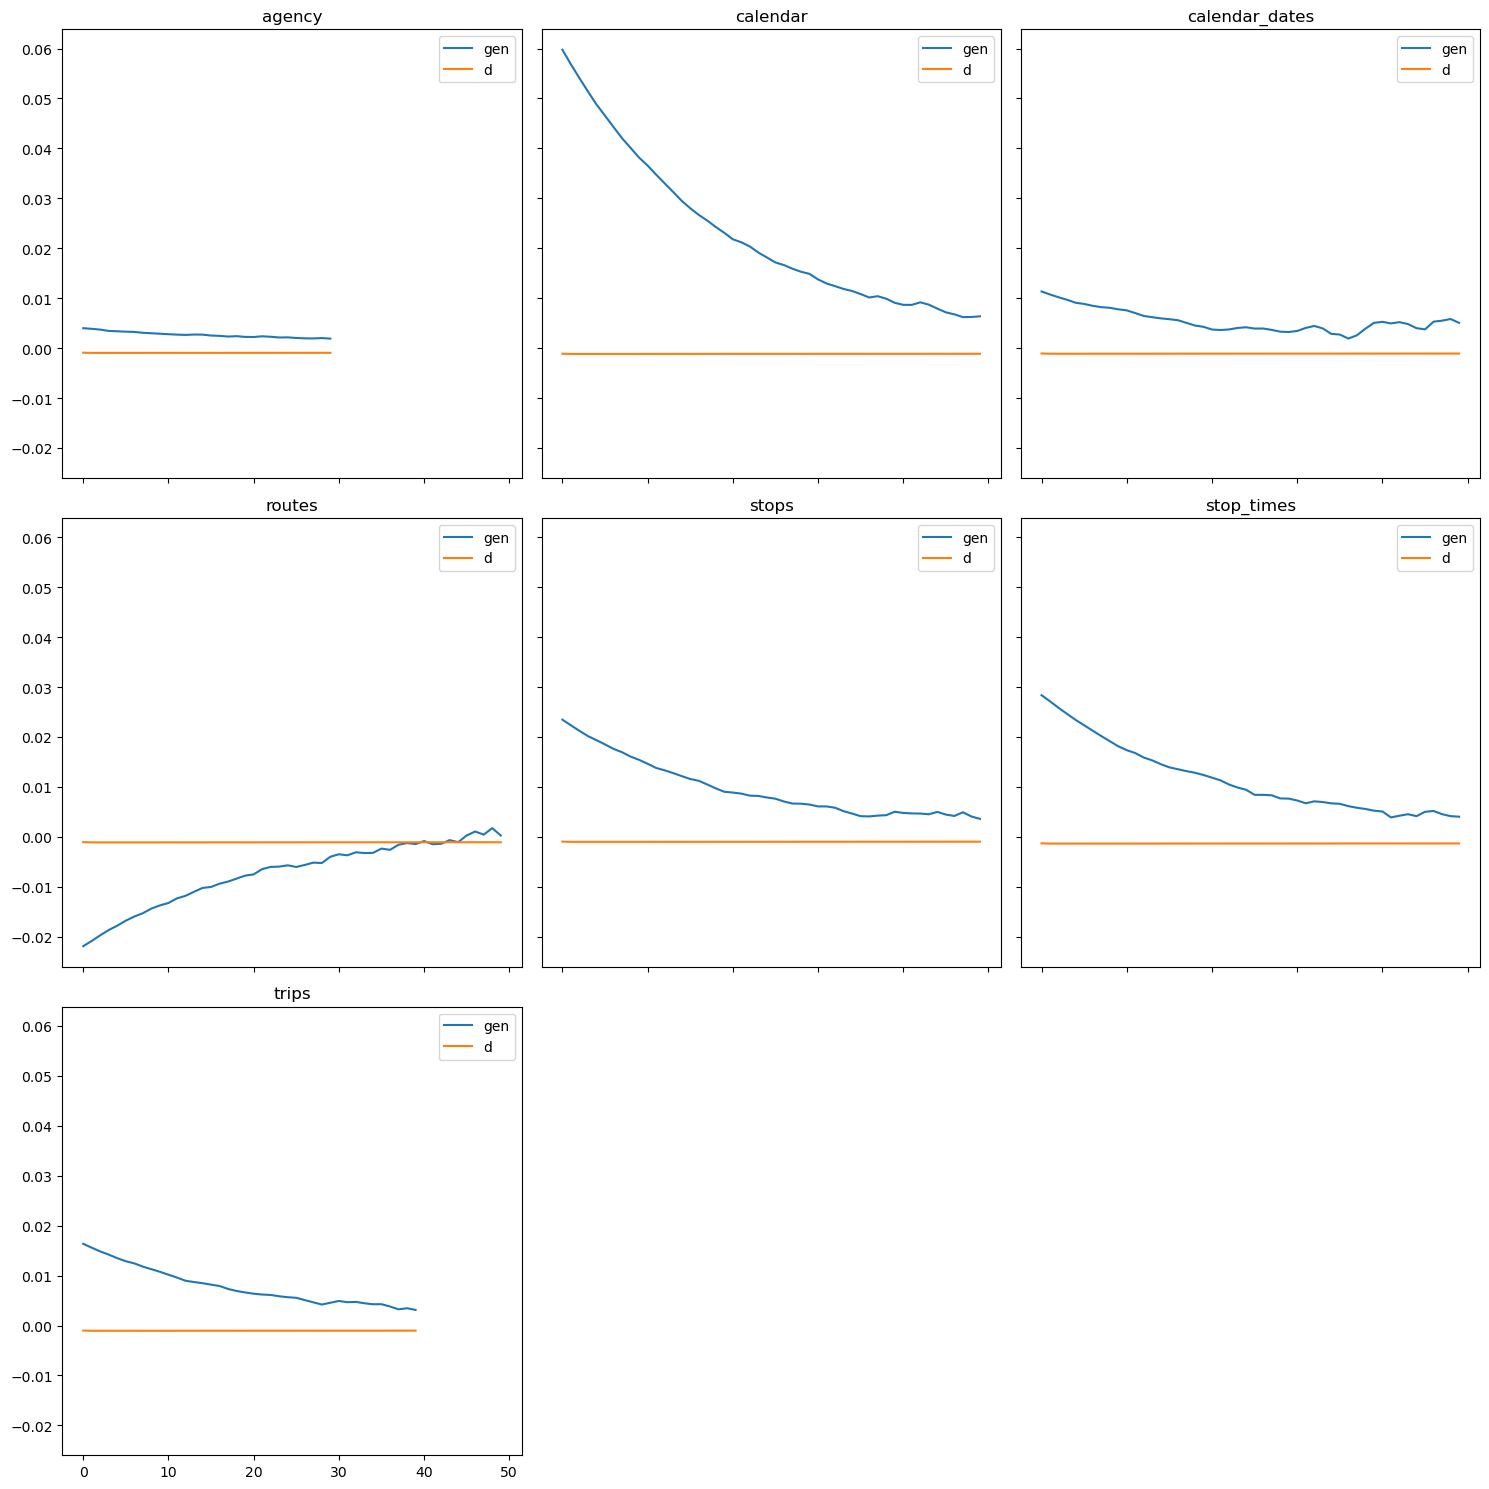

Total Time Used: 2m 16s


In [53]:
collection_training(processed_data_collection, training_parameter_dict)

# Synthetic Data Generation

In [54]:
# table_name:
# {'table':table, # df
#  'labels':labels, # df
#  'scaler':scaler, # a scaler object
#  'table_col_names':table_columns, # list of col names
#  'label_col_names':label_columns, # list of col names
#  'metadata':metadata[df_name]} # a metadata dict (see below)

# metadata
# {'primary_key':primary_key, # list, [column names, number_of_unique_ids]
#  'parent':parent, # dict, {parent_name:shared_id_column_name, ...}
#  'child':child} # str, child_name

In [55]:
# def generate_individual_synth_data(generator, labels, seed=123):
#     pass

In [56]:
def resample_array(array, size):
    og_size = len(array)
    x_og = np.linspace(0, 1, og_size)
    x_new = np.linspace(0, 1, size)
    array_resampled = np.interp(x_new, x_og, array)
    return array_resampled.astype(int)

In [57]:
def get_distribution(array):
    unique_elements, counts = np.unique(array, return_counts=True)
    prob_distribution = counts / counts.sum()
    return unique_elements, prob_distribution

In [58]:
def generate_new_array(size, unique_elements, prob_distribution):
    new_array = np.random.choice(unique_elements, size=size, p=prob_distribution)
    return new_array

In [64]:
def generate_synth_data_collection(processed_data_collection, generation_dict, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    for df_name, content in processed_data_collection.items():
        generator = models.load_model('models_single/'+df_name+'_gan.h5')
        latent_dim = 100
        noise = np.random.uniform(-1, 1, size=(generation_dict[df_name]['nrows'], latent_dim))
        raw_fake_data = generator.predict(noise)
        scaled_fake_data = content['scaler'].inverse_transform(raw_fake_data)
        fake_df = pd.DataFrame(scaled_fake_data, columns=content['col_names'])
        # fake_data = pd.concat([fake_labels_df, fake_table_df], axis=1)
        
        columns_to_int = [col for col in fake_df.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            fake_df[col] = fake_df[col].astype(int)
                
        synthetic_data_collection[df_name] = fake_df
        
    return synthetic_data_collection

In [61]:
generation_dict = {k:{'nrows':len(v['scaled_data'])} for k,v in processed_data_collection.items()}

In [62]:
generation_dict

{'agency': {'nrows': 15},
 'calendar': {'nrows': 121},
 'calendar_dates': {'nrows': 674},
 'routes': {'nrows': 215},
 'stops': {'nrows': 6714},
 'stop_times': {'nrows': 966790},
 'trips': {'nrows': 32403}}

In [65]:
synthetic_data_collection = generate_synth_data_collection(processed_data_collection, generation_dict)

# Metrics

## Pre-metrics Data Processing

In [ ]:
# def convert_to_dataframe_collection(processed_data_collection):
#     new_dict = {}
#     features_to_ignore_rounding = ['shape_pt_lat',
#                       'shape_pt_lon',
#                       'stop_lat',
#                       'stop_lon',
#                      'shape_dist_traveled']
#     for df_name, content in processed_data_collection.items():
#         table_scaler = content['table_scaler']
#         labels_scaler = content['labels_scaler']
#         labels = content['labels']
#         table = content['table']
#         table = pd.DataFrame(table_scaler.inverse_transform(table),columns = content['table_col_names'])
#         labels = pd.DataFrame(labels_scaler.inverse_transform(labels),columns = content['labels_col_names'])
#         new_df = pd.concat([labels, table], axis=1)
#         columns_to_int = [col for col in new_df.columns if col not in features_to_ignore_rounding]
#         for col in columns_to_int:
#             new_df[col] = new_df[col].astype(int)
#         new_dict[df_name] = new_df
#     return new_dict

In [ ]:
# real_data_collection = convert_to_dataframe_collection(processed_data_collection)

In [ ]:
# del processed_data_collection

In [66]:
synthetic_data_collection

{'agency':     agency_id  agency_url  agency_timezone  agency_lang  agency_phone
 0           7           0                0            0             0
 1          11           0                0            0             0
 2           6           0                0            0             0
 3           7           0                0            0             0
 4           8           0                0            0             0
 5           8           0                0            0             0
 6           8           0                0            0             0
 7           6           0                0            0             0
 8           6           0                0            0             0
 9           5           0                0            0             0
 10          7           0                0            0             0
 11          9           0                0            0             0
 12          8           0                0            0           

In [67]:
real_data_collection

{'agency':     agency_id  agency_url  agency_timezone  agency_lang  agency_phone
 0           0           0                0            0             0
 1           1           0                0            0             0
 2           2           0                0            0             0
 3           3           0                0            0             0
 4           4           0                0            0             0
 5           5           0                0            0             0
 6           6           0                0            0             0
 7           7           0                0            0             0
 8           8           0                0            0             0
 9           9           0                0            0             0
 10         10           0                0            0             0
 11         11           0                0            0             0
 12         12           0                0            0           

### Cosine Similarity Test

In [68]:
def cos_test(fake_collection, real_collection):
    test_dict = {}
    for df_name in fake_collection.keys():
        mean_cos = []
        mean_cos.append(metrics.pairwise.cosine_similarity(real_collection[df_name].values.T, fake_collection[df_name].values.T))
        test_dict[df_name] = np.mean(mean_cos)
    return test_dict

In [69]:
cos_test(synthetic_data_collection, real_data_collection)

{'agency': 0.030859036140956295,
 'calendar': 0.21346289962794632,
 'calendar_dates': 0.9228293398244669,
 'routes': 0.35541410287160313,
 'stops': 0.1874253308122589,
 'stop_times': 0.4359771939071462,
 'trips': 0.3891128404191231}

### KS (Kolmogorov-Smirnov) Test

In [ ]:
# def batch_ks_test(fake_collection, real_collection):
#     stats_dict = {}
#     for df_name, fake_df in fake_collection.items():
#         stats_list = []
#         p_val_list = []
#         test_dict = {}
#         for col in fake_df.columns:
#             stats, p_val = ks_2samp(fake_df[col], real_collection[df_name][col], alternative='two-sided', method='auto')
#             stats_list.append(stats)
#             p_val_list.append(p_val)
#         test_dict['stats'] = np.mean(stats_list)
#         test_dict['p_value'] = np.mean(p_val_list)
#         stats_dict[df_name] = test_dict
#     return stats_dict

In [70]:
def ks_test(df1, df2):
    ks_stats = []
    wasserstein_distances = []
    p_values = []
    for column in df1.columns:
        ks_stat, ks_p_value = ks_2samp(df1[column], df2[column])
        ks_stats.append(ks_stat)
        p_values.append(ks_p_value)
        w_dist = wasserstein_distance(df1[column], df2[column])
        wasserstein_distances.append(w_dist)
    mean_ks_stat = np.mean(ks_stats)
    mean_wasserstein_distance = np.mean(wasserstein_distances)
    mean_p_value = np.mean(p_values)
    return mean_ks_stat, mean_wasserstein_distance, mean_p_value

In [71]:
def batch_ks_test(collection1, collection2):
    stats_dict = {}
    for df_name in collection1:
        ks_results, wasserstein_results, p_value = ks_test(collection1[df_name], collection2[df_name])
        stats_dict[df_name] = {
            'statistics':ks_results,
            'w_distance':wasserstein_results,
            'p_value':p_value
        }
    return stats_dict

In [72]:
batch_ks_test(synthetic_data_collection, real_data_collection)

{'agency': {'statistics': 0.05333333333333333,
  'w_distance': 0.4800000000000001,
  'p_value': 0.9356276454136193},
 'calendar': {'statistics': 0.48099173553719005,
  'w_distance': 5.074380165289256,
  'p_value': 2.2886313972869016e-05},
 'calendar_dates': {'statistics': 0.3931750741839763,
  'w_distance': 9.959940652818991,
  'p_value': 5.572969250604218e-23},
 'routes': {'statistics': 0.5062015503875968,
  'w_distance': 6.18139534883721,
  'p_value': 1.9721010671482594e-06},
 'stops': {'statistics': 0.5703174130341243,
  'w_distance': 97.95858178258919,
  'p_value': 0.13709161803696993},
 'stop_times': {'statistics': 0.29640097642714547,
  'w_distance': 1849.3712407167652,
  'p_value': 0.003974767821554648},
 'trips': {'statistics': 0.28316822516433665,
  'w_distance': 766.8516881152979,
  'p_value': 0.25}}